In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

import gensim
from gensim import corpora

**Pandas Confiigurations**

In [ ]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

In [4]:
cc1_file =  'creditcard_sampledata.csv'
cc3_file =  'creditcard_sampledata_3.csv'

**Reading data form creditcard_sampledata_3.csv**

In [5]:
df = pd.read_csv(cc3_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5050 non-null   int64  
 1   V1          5050 non-null   float64
 2   V2          5050 non-null   float64
 3   V3          5050 non-null   float64
 4   V4          5050 non-null   float64
 5   V5          5050 non-null   float64
 6   V6          5050 non-null   float64
 7   V7          5050 non-null   float64
 8   V8          5050 non-null   float64
 9   V9          5050 non-null   float64
 10  V10         5050 non-null   float64
 11  V11         5050 non-null   float64
 12  V12         5050 non-null   float64
 13  V13         5050 non-null   float64
 14  V14         5050 non-null   float64
 15  V15         5050 non-null   float64
 16  V16         5050 non-null   float64
 17  V17         5050 non-null   float64
 18  V18         5050 non-null   float64
 19  V19         5050 non-null  

In [6]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,258647,1.725265,-1.337256,-1.012687,-0.361656,-1.431611,-1.098681,-0.842274,-0.026594,-0.032409,0.215113,1.618952,-0.654046,-1.442665,-1.546538,-0.230008,1.785539,1.419793,0.071666,0.233031,0.275911,0.414524,0.793434,0.028887,0.419421,-0.367529,-0.155634,-0.015768,0.010790,189.00,0
1,69263,0.683254,-1.681875,0.533349,-0.326064,-1.455603,0.101832,-0.520590,0.114036,-0.601760,0.444011,1.521570,0.499202,-0.127849,-0.237253,-0.752351,0.667190,0.724785,-1.736615,0.702088,0.638186,0.116898,-0.304605,-0.125547,0.244848,0.069163,-0.460712,-0.017068,0.063542,315.17,0
2,96552,1.067973,-0.656667,1.029738,0.253899,-1.172715,0.073232,-0.745771,0.249803,1.383057,-0.483771,-0.782780,0.005242,-1.273288,-0.269260,0.091287,-0.347973,0.495328,-0.925949,0.099138,-0.083859,-0.189315,-0.426743,0.079539,0.129692,0.002778,0.970498,-0.035056,0.017313,59.98,0
3,281898,0.119513,0.729275,-1.678879,-1.551408,3.128914,3.210632,0.356276,0.920374,-0.160589,-0.801748,0.137341,-0.156740,-0.429388,-0.752392,0.155272,0.215068,0.352222,-0.376168,-0.398920,0.043715,-0.335825,-0.906171,0.108350,0.593062,-0.424303,0.164201,0.245881,0.071029,0.89,0
4,86917,1.271253,0.275694,0.159568,1.003096,-0.128535,-0.608730,0.088777,-0.145336,0.156047,0.022707,-0.963306,-0.228074,-0.324933,0.390609,1.065923,0.285930,-0.627072,0.170175,-0.215912,-0.147394,0.031958,0.123503,-0.174528,-0.147535,0.735909,-0.262270,0.015577,0.015955,6.53,0


In [7]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

0    5000
1      50
Name: Class, dtype: int64

In [8]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.009900990099009901
Ratio of non-fraudulent cases: 0.9900990099009901


In [9]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

In [10]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

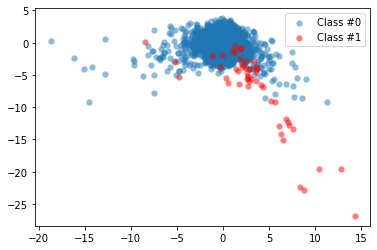

In [11]:
# Create X and y from the prep_data function 
X, y = prep_data(df)
# Plot our data by running our plot data function on X and y
plot_data(X, y)

**By visualizing the data, you can immediately see how our fraud cases are scattered over our data, and how few cases we have. A picture often makes the imbalance problem clear. In the next exercises we'll visually explore how to improve our fraud to non-fraud balance.**

When to use resmapling methods

Use resampling methods on the training set, not on the test set

The goal is to produce a better model by providing balanced data

The goal is not to predict the synthetic samples
Test data should be free of duplicates and synthetic data
Only test the model on real data

First, spit the data into train and test sets

X shape: (5050, 28)
y shape: (5050,)


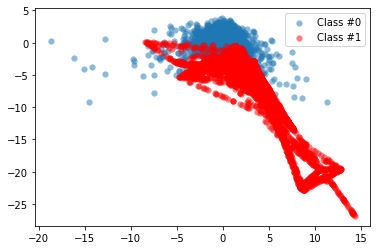

In [20]:
# Run the prep_data function
X, y = prep_data(df)
print(f'X shape: {X.shape}\ny shape: {y.shape}')
# Define the resampling method
method = SMOTE()
# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)
# Plot the resampled data
plot_data(X_resampled, y_resampled)

**The minority class is now much more prominently visible in our data. To see the results of SMOTE even better, we'll compare it to the original data in the next exercise.**

In [22]:
pd.value_counts(pd.Series(y))


0    5000
1      50
dtype: int64

In [23]:
pd.value_counts(pd.Series(y_resampled))

0    5000
1    5000
dtype: int64

In [24]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

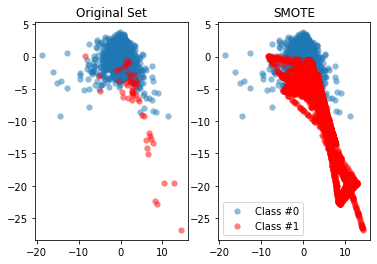

In [25]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

**ML Based Systems**

Adapt to the data, thus can change over time

Uses all the data combined, rather than a threshold per feature

Produces a probability, rather than a binary score

Typically have better performance and can be combined with rules

In [26]:
# Step 1: split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [27]:
# Step 2: Define which model to use
model = LinearRegression()

In [28]:
# Step 3: Fit the model to the training data
model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Step 4: Obtain model predictions from the test data
y_predicted = model.predict(X_test)

In [30]:
# Step 5: Compare y_test to predictions and obtain performance metrics (r^2 score)
r2_score(y_test, y_predicted)

0.6636194556152362

**Exploring the traditional method of fraud detection**

In [31]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [32]:
df.groupby('Class').mean()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.035030,0.011553,0.037444,-0.045760,-0.013825,-0.030885,0.014315,-0.022432,-0.002227,0.001667,-0.004511,0.017434,0.004204,0.006542,-0.026640,0.001190,0.004481,-0.010892,-0.016554,-0.002896,-0.010583,-0.010206,-0.003305,-0.000918,-0.002613,-0.004651,-0.009584,0.002414,85.843714
1,-4.985211,3.321539,-7.293909,4.827952,-3.326587,-1.591882,-5.776541,1.395058,-2.537728,-5.917934,4.020563,-7.032865,-0.104179,-7.100399,-0.120265,-4.658854,-7.589219,-2.650436,0.894255,0.194580,0.703182,0.069065,-0.088374,-0.029425,-0.073336,-0.023377,0.380072,0.009304,113.469000


In [33]:
df['flag_as_fraud'] = np.where(np.logical_and(df.V1 < -3, df.V3 < -5), 1, 0)

In [34]:
pd.crosstab(df.Class, df.flag_as_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud'])


Flagged Fraud,0,1
Actual Fraud,,
0,4984,16
1,28,22


***With this rule, 22 out of 50 fraud cases are detected, 28 are not detected, and 16 false positives are identified.***



1.   **Using ML classification to catch fraud**
2.   Logistic Regression



In [35]:
# Create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [36]:
# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [37]:
# Obtain model predictions
predicted = model.predict(X_test)

In [38]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.89      0.80      0.84        10

    accuracy                           1.00      1515
   macro avg       0.94      0.90      0.92      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1504    1]
 [   2    8]]


*** We are getting far fewer false positives, so that's an improvement. Also, we're catching a higher percentage of fraud cases, so that is also better than before. We are using only our test data to calculate the model results on. We're comparing the crosstab on the full dataset from the last run, with a confusion matrix of only 30% of the total dataset, so that's where that difference comes from.***

**Logistic regression with SMOTE**

In [39]:
# Define which resampling method and which ML model to use in the pipeline
# resampling = SMOTE(kind='borderline2')  # has been changed to BorderlineSMOTE
resampling = BorderlineSMOTE()
model = LogisticRegression(solver='liblinear')

In [40]:
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

In [41]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

In [43]:
# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classifcation report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1505
           1       0.62      1.00      0.77        10

    accuracy                           1.00      1515
   macro avg       0.81      1.00      0.88      1515
weighted avg       1.00      1.00      1.00      1515

Confusion matrix:
 [[1499    6]
 [   0   10]]


***As we can see, the SMOTE slightly improves our results. We now manage to find all cases of fraud, but we have a slightly higher number of false positives, albeit only 7 cases.  Resampling doesn't necessarily lead to better results. When the fraud cases are very spread and scattered over the data, using SMOTE can introduce a bit of bias. Nearest neighbors aren't necessarily also fraud cases, so the synthetic samples might 'confuse' the model slightly.***